In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.cluster import AgglomerativeClustering
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import pickle

In [2]:
# Import artist and track data

tracks_raw = pd.read_csv('../../capstone1/spotify_data/tracks.csv')
artists_raw = pd.read_csv('../../capstone1/spotify_data/artists.csv')

In [3]:
### Explore artists

print('artists shape: {}'.format(artists_raw.shape))
print('columns: {}'.format(artists_raw.columns))

artists shape: (1104349, 5)
columns: Index(['id', 'followers', 'genres', 'name', 'popularity'], dtype='object')


In [5]:
# Copy and process raw artist genre data
artist_genres = artists_raw[artists_raw['genres'] != '[]'].copy()
artist_genres['genres_clean'] = artist_genres['genres'].str.strip("[]")
artist_genres['genre_count'] = artist_genres['genres'].str.count(',') + 1
artist_split = artist_genres.assign(genres=artist_genres['genres_clean'].str.split(', ')).explode('genres')
artist_split['genres'] = artist_split['genres'].str.strip("'")

artist_split['id_artists'] = artist_split['id']
artist_split.drop(columns='genres_clean')

print('{} artists total'.format(artists_raw.shape[0]))
print('{} artists with labeled genres'.format(artist_genres.shape[0]))
print('{} genre-artist pairs after processing'.format(artist_split.shape[0]))


# Copy and process track raw track data

tracks = tracks_raw[tracks_raw['id_artists'] != '[]'].copy()
tracks['id_artists_clean'] = tracks['id_artists'].str.strip("[]")
tracks['artist_count'] = tracks['id_artists_clean'].str.count(',') + 1
tracks_3_artists = tracks[tracks['artist_count'] < 4]
tracks_split = tracks_3_artists.assign(id_artists=tracks_3_artists['id_artists_clean'].str.split(', ')).explode('id_artists')
tracks_split['id_artists'] = tracks_split['id_artists'].str.strip("'")
tracks_split.drop(columns=['id_artists_clean'], inplace=True)

print('{} tracks total'.format(tracks_raw.shape[0]))
print('{} tracks with 3 or fewer artists'.format(tracks_3_artists.shape[0]))
print('{} track-artist pairs after processing'.format(tracks_split.shape[0]))

1104349 artists total
298616 artists with labeled genres
460843 genre-artist pairs after processing
586672 tracks total
574073 tracks with 3 or fewer artists
689217 track-artist pairs after processing


In [6]:
# Remove exceptionally rare genres

print('median number of arists per genre: {}'.format(artist_split['genres'].value_counts().quantile(0.5)))
top_1000_genres = artist_split['genres'].value_counts()[:1000].index
top_500_genres = artist_split['genres'].value_counts()[:500].index
top_50_genres = artist_split['genres'].value_counts()[:50].index

artist_1000_genres = artist_split[artist_split['genres'].isin(top_1000_genres)]
artist_500_genres = artist_split[artist_split['genres'].isin(top_500_genres)]
artist_50_genres = artist_split[artist_split['genres'].isin(top_50_genres)]

median number of arists per genre: 61.0


In [7]:
tracks_artists = artist_split.merge(tracks_split, on='id_artists')
print('{} track-artist-genre combinations with all genres'.format(tracks_artists.shape[0]))
tracks_artists_1000 = artist_1000_genres.merge(tracks_split, on='id_artists')
print('{} track-artist-genre combinations with 1000 genres'.format(tracks_artists_1000.shape[0]))
tracks_artists_500 = artist_500_genres.merge(tracks_split, on='id_artists')
print('{} track-artist-genre combinations with 500 genres'.format(tracks_artists_500.shape[0]))
tracks_artists_50 = artist_50_genres.merge(tracks_split, on='id_artists')
print('{} track-artist-genre combinations with 50 genres'.format(tracks_artists_50.shape[0]))

2077522 track-artist-genre combinations with all genres
1543623 track-artist-genre combinations with 1000 genres
1288650 track-artist-genre combinations with 500 genres
317522 track-artist-genre combinations with 50 genres


In [8]:
# trim dataframe for dimensionality reduction

print(tracks_artists_50.columns)
tracks_artists_50_clean = tracks_artists_50[['genres','danceability',
       'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']]

print(tracks_artists_50_clean.columns)

Index(['id_x', 'followers', 'genres', 'name_x', 'popularity_x', 'genres_clean',
       'genre_count', 'id_artists', 'id_y', 'name_y', 'popularity_y',
       'duration_ms', 'explicit', 'artists', 'release_date', 'danceability',
       'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
       'artist_count'],
      dtype='object')
Index(['genres', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'time_signature'],
      dtype='object')


In [9]:
# trial run with 50 genres
X_train, X_test, y_train, y_test = train_test_split(tracks_artists_50_clean.iloc[:, 1:], tracks_artists_50_clean.iloc[:, :1])

In [10]:
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)

<ipython-input-10-857f22dbcaec>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_clf.fit(X_train, y_train)


RandomForestClassifier()

In [176]:
pickle.dump(rf_clf, open('../models/rf_clf.plk', 'wb'))

In [11]:
rf_pred = rf_clf.predict(X_test)


In [13]:
print(classification_report(y_test, rf_pred))


                         precision    recall  f1-score   support

        adult standards       0.50      0.60      0.55      6836
        alternative r&b       0.04      0.03      0.03       133
       background music       0.50      0.15      0.24        13
   calming instrumental       0.00      0.00      0.00        12
  classical performance       0.87      0.91      0.89      3107
                corrido       0.69      0.59      0.64       904
           country rock       0.16      0.12      0.14      2909
              dance pop       0.06      0.06      0.06      3245
                    edm       0.04      0.04      0.04      1390
          electro house       0.05      0.04      0.04       503
             electropop       0.05      0.04      0.04       604
            escape room       0.08      0.10      0.09        71
                europop       0.25      0.18      0.21      1679
                  filmi       0.72      0.82      0.77      6584
         french hip hop 

In [52]:
for classes, probs in zip(rf_clf.classes_, rf_clf.predict_proba(np.array(test).reshape(1,-1))[0]):
    print(round(probs,2), classes)


0.0 adult standards
0.0 alternative r&b
0.0 background music
0.0 calming instrumental
0.0 classical performance
0.01 corrido
0.0 country rock
0.07 dance pop
0.0 edm
0.0 electro house
0.01 electropop
0.0 escape room
0.0 europop
0.0 filmi
0.01 french hip hop
0.0 funk
0.02 german hip hop
0.01 german pop
0.03 hip hop
0.0 indian classical
0.0 indie folk
0.0 indie pop
0.0 indie poptimism
0.0 indie rock
0.0 k-pop
0.0 latin
0.0 latin rock
0.0 lo-fi beats
0.0 modern alternative rock
0.0 modern rock
0.0 new wave pop
0.0 otacore
0.05 pop
0.01 pop dance
0.0 pop edm
0.02 pop rap
0.0 pop rock
0.64 post-teen pop
0.0 progressive house
0.01 r&b
0.04 rap
0.0 rock
0.0 rock en espanol
0.0 soft rock
0.0 stomp and holler
0.03 trap
0.0 tropical
0.01 tropical house
0.0 underground hip hop
0.03 urban contemporary


In [53]:
test = tracks_artists_50.iloc[317519]
test

id_x                            46MWeeHNVMYRIIofQBEX98
followers                                      33520.0
genres                             underground hip hop
name_x                                            BEAM
popularity_x                                        72
genres_clean        'trap soul', 'underground hip hop'
genre_count                                          2
id_artists                      46MWeeHNVMYRIIofQBEX98
id_y                            27UcQ6dAvQrgH9C880rCM3
name_y                 Love You Different (feat. BEAM)
popularity_y                                        80
duration_ms                                     186696
explicit                                             0
artists                      ['Justin Bieber', 'BEAM']
release_date                                2021-03-19
danceability                                     0.759
energy                                           0.584
key                                                  8
loudness  

In [23]:
test = test[['danceability',
       'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']]

In [31]:
np.array(test).reshape(1,-1)

(12,)

In [38]:
rf_clf.classes_

array(['adult standards', 'alternative r&b', 'background music',
       'calming instrumental', 'classical performance', 'corrido',
       'country rock', 'dance pop', 'edm', 'electro house', 'electropop',
       'escape room', 'europop', 'filmi', 'french hip hop', 'funk',
       'german hip hop', 'german pop', 'hip hop', 'indian classical',
       'indie folk', 'indie pop', 'indie poptimism', 'indie rock',
       'k-pop', 'latin', 'latin rock', 'lo-fi beats',
       'modern alternative rock', 'modern rock', 'new wave pop',
       'otacore', 'pop', 'pop dance', 'pop edm', 'pop rap', 'pop rock',
       'post-teen pop', 'progressive house', 'r&b', 'rap', 'rock',
       'rock en espanol', 'soft rock', 'stomp and holler', 'trap',
       'tropical', 'tropical house', 'underground hip hop',
       'urban contemporary'], dtype=object)

In [43]:
rf_clf.predict_proba(np.array(test).reshape(1,-1))

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.01      , 0.        , 0.06515152, 0.005     , 0.00083333,
        0.01098485, 0.        , 0.        , 0.        , 0.01      ,
        0.        , 0.02      , 0.01      , 0.02616667, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.005     ,
        0.        , 0.        , 0.05148485, 0.01166667, 0.00083333,
        0.0195    , 0.        , 0.63606818, 0.        , 0.00983333,
        0.03625   , 0.        , 0.        , 0.        , 0.        ,
        0.03116667, 0.        , 0.00972727, 0.        , 0.03033333]])

(0.0, 10.0)

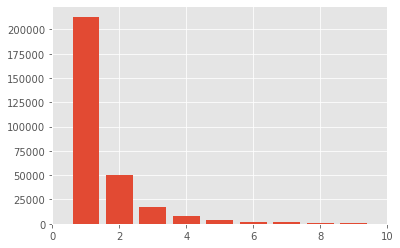

In [60]:
# Genre tags for each artist
genre_counts_per_artist = genre_df['genre_count'].value_counts()

fig, ax = plt.subplots()
ax.bar(genre_counts_per_artist.index, genre_counts_per_artist.values)
ax.set_xlim(0, 10)

count    5365.000000
mean       85.898043
std        71.625160
min         1.000000
25%        38.000000
50%        61.000000
75%       113.000000
max       572.000000
Name: genres, dtype: float64

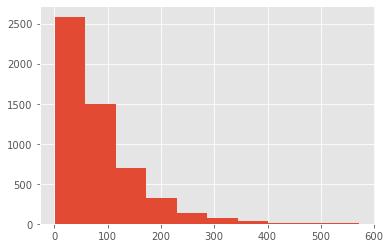

In [63]:
# Split genre tags for each artist

genre_counts = genre_split['genres'].value_counts()

fig, ax = plt.subplots()
ax.hist(genre_counts)
# ax.set_xlim(0, 10)
genre_counts.describe()

In [65]:
tracks

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,['Uli'],['45tIt06XoI0Iio4LBEVpls'],1922-02-22,0.645,0.4450,0,-13.338,1,0.4510,0.674,0.744000,0.1510,0.1270,104.851,3
1,021ht4sdgPcrDgSk7JTbKY,Capítulo 2.16 - Banquero Anarquista,0,98200,0,['Fernando Pessoa'],['14jtPCOoNZwquk5wd9DxrY'],1922-06-01,0.695,0.2630,0,-22.136,1,0.9570,0.797,0.000000,0.1480,0.6550,102.009,1
2,07A5yehtSnoedViJAZkNnc,Vivo para Quererte - Remasterizado,0,181640,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.434,0.1770,1,-21.180,1,0.0512,0.994,0.021800,0.2120,0.4570,130.418,5
3,08FmqUhxtyLTn6pAh6bk45,El Prisionero - Remasterizado,0,176907,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.321,0.0946,7,-27.961,1,0.0504,0.995,0.918000,0.1040,0.3970,169.980,3
4,08y9GfoqCWfOGsKdwojr5e,Lady of the Evening,0,163080,0,['Dick Haymes'],['3BiJGZsyX9sJchTqcSA7Su'],1922,0.402,0.1580,3,-16.900,0,0.0390,0.989,0.130000,0.3110,0.1960,103.220,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
586667,5rgu12WBIHQtvej2MdHSH0,云与海,50,258267,0,['阿YueYue'],['1QLBXKM5GCpyQQSVMNZqrZ'],2020-09-26,0.560,0.5180,0,-7.471,0,0.0292,0.785,0.000000,0.0648,0.2110,131.896,4
586668,0NuWgxEp51CutD2pJoF4OM,blind,72,153293,0,['ROLE MODEL'],['1dy5WNgIKQU6ezkpZs4y8z'],2020-10-21,0.765,0.6630,0,-5.223,1,0.0652,0.141,0.000297,0.0924,0.6860,150.091,4
586669,27Y1N4Q4U3EfDU5Ubw8ws2,What They'll Say About Us,70,187601,0,['FINNEAS'],['37M5pPGs6V1fchFJSgCguX'],2020-09-02,0.535,0.3140,7,-12.823,0,0.0408,0.895,0.000150,0.0874,0.0663,145.095,4
586670,45XJsGpFTyzbzeWK8VzR8S,A Day At A Time,58,142003,0,"['Gentle Bones', 'Clara Benin']","['4jGPdu95icCKVF31CcFKbS', '5ebPSE9YI5aLeZ1Z2g...",2021-03-05,0.696,0.6150,10,-6.212,1,0.0345,0.206,0.000003,0.3050,0.4380,90.029,4


In [67]:
# Clustering of genres

# Link genre to artists
genre_split

,id,followers,genres,name,popularity,genre_count,id_artists
45,0VLMVnVbJyJ4oyZs2L3Yl2,71.0,'carnaval cadiz',Las Viudas De Los Bisabuelos,6,1,0VLMVnVbJyJ4oyZs2L3Yl2
46,0dt23bs4w8zx154C5xdVyl,63.0,'carnaval cadiz',Los De Capuchinos,5,1,0dt23bs4w8zx154C5xdVyl
47,0pGhoB99qpEJEsBQxgaskQ,64.0,'carnaval cadiz',Los “Pofesionales”,7,1,0pGhoB99qpEJEsBQxgaskQ
48,3HDrX2OtSuXLW5dLR85uN3,53.0,'carnaval cadiz',Los Que No Paran De Rajar,6,1,3HDrX2OtSuXLW5dLR85uN3
136,22mLrN5fkppmuUPsHx6i2G,59.0,'classical harp',Vera Dulova,3,2,22mLrN5fkppmuUPsHx6i2G
...,...,...,...,...,...,...,...
1104328,1q9C5XlekzXbRLIuLCDTre,90087.0,'teen pop',Brent Rivera,33,2,1q9C5XlekzXbRLIuLCDTre
1104331,4fh2BIKYPFvXFsQLhaeVJp,309.0,'la indie',Lone Kodiak,20,1,4fh2BIKYPFvXFsQLhaeVJp
1104334,7akMsd2vb4xowNTehv3gsY,774.0,'indie rockism',The Str!ke,0,1,7akMsd2vb4xowNTehv3gsY
1104336,35m7AJrUCtHYHyIUhCzmgi,205.0,'indie rockism',Hunter Fraser,6,1,35m7AJrUCtHYHyIUhCzmgi


In [ ]:

# Link artists to tracks

# Cluster genres based on track features

In [ ]:
# Classifier training